<a href="https://www.kaggle.com/code/utkarshx27/machine-failure-prediction?scriptVersionId=133559470" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv
/kaggle/input/machine-failure-predictions/machine failure.csv


In [2]:
import math
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostRegressor as cbr
from lightgbm import LGBMRegressor as lgbmr
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s3e17/sample_submission.csv')

In [4]:
train.head(2)

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0


In [5]:
test.head(2)

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0


In [6]:
sample_sub.head(2)

,id,Machine failure
0,136429,0.5
1,136430,0.5


In [7]:
train.columns = train.columns.str.replace('[\[\]]', '', regex=True)
train.columns

Index(['id', 'Product ID', 'Type', 'Air temperature K',
       'Process temperature K', 'Rotational speed rpm', 'Torque Nm',
       'Tool wear min', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [8]:
def summary(df):
    print(f'data shape: {df.shape}')  
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['missing'] = df.isnull().sum().values 
    summ['missing'] = df.isnull().sum().values / len(df)* 100
    summ['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ
summary(train)

data shape: (136429, 14)


,data type,missing,unique,min,max
id,int64,0.0,136429,0.0,136428.0
Product ID,object,0.0,9976,NaN,NaN
Type,object,0.0,3,NaN,NaN
Air temperature K,float64,0.0,95,295.3,304.4
Process temperature K,float64,0.0,81,305.8,313.8
Rotational speed rpm,int64,0.0,952,1181.0,2886.0
Torque Nm,float64,0.0,611,3.8,76.6
Tool wear min,int64,0.0,246,0.0,253.0
Machine failure,int64,0.0,2,0.0,1.0
TWF,int64,0.0,2,0.0,1.0


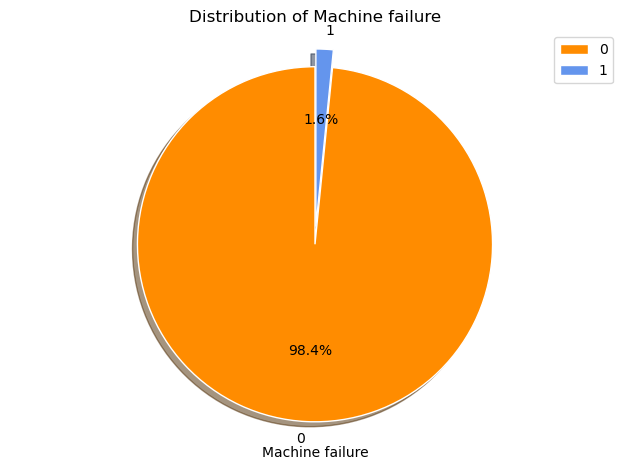

In [9]:
class_counts = train['Machine failure'].value_counts()

colors = ['#FF8C00', '#6495ED']

plt.pie(class_counts, 
        labels=class_counts.index, 
        autopct='%1.1f%%',
        colors=colors,           
        shadow=True,             
        startangle=90,            
        explode=(0.1, 0),        
        wedgeprops={'edgecolor': 'white'} 
        )

plt.legend(class_counts.index, loc='best')
plt.xlabel('Machine failure')
plt.title('Distribution of Machine failure')

plt.axis('equal')
plt.tight_layout()

plt.show()

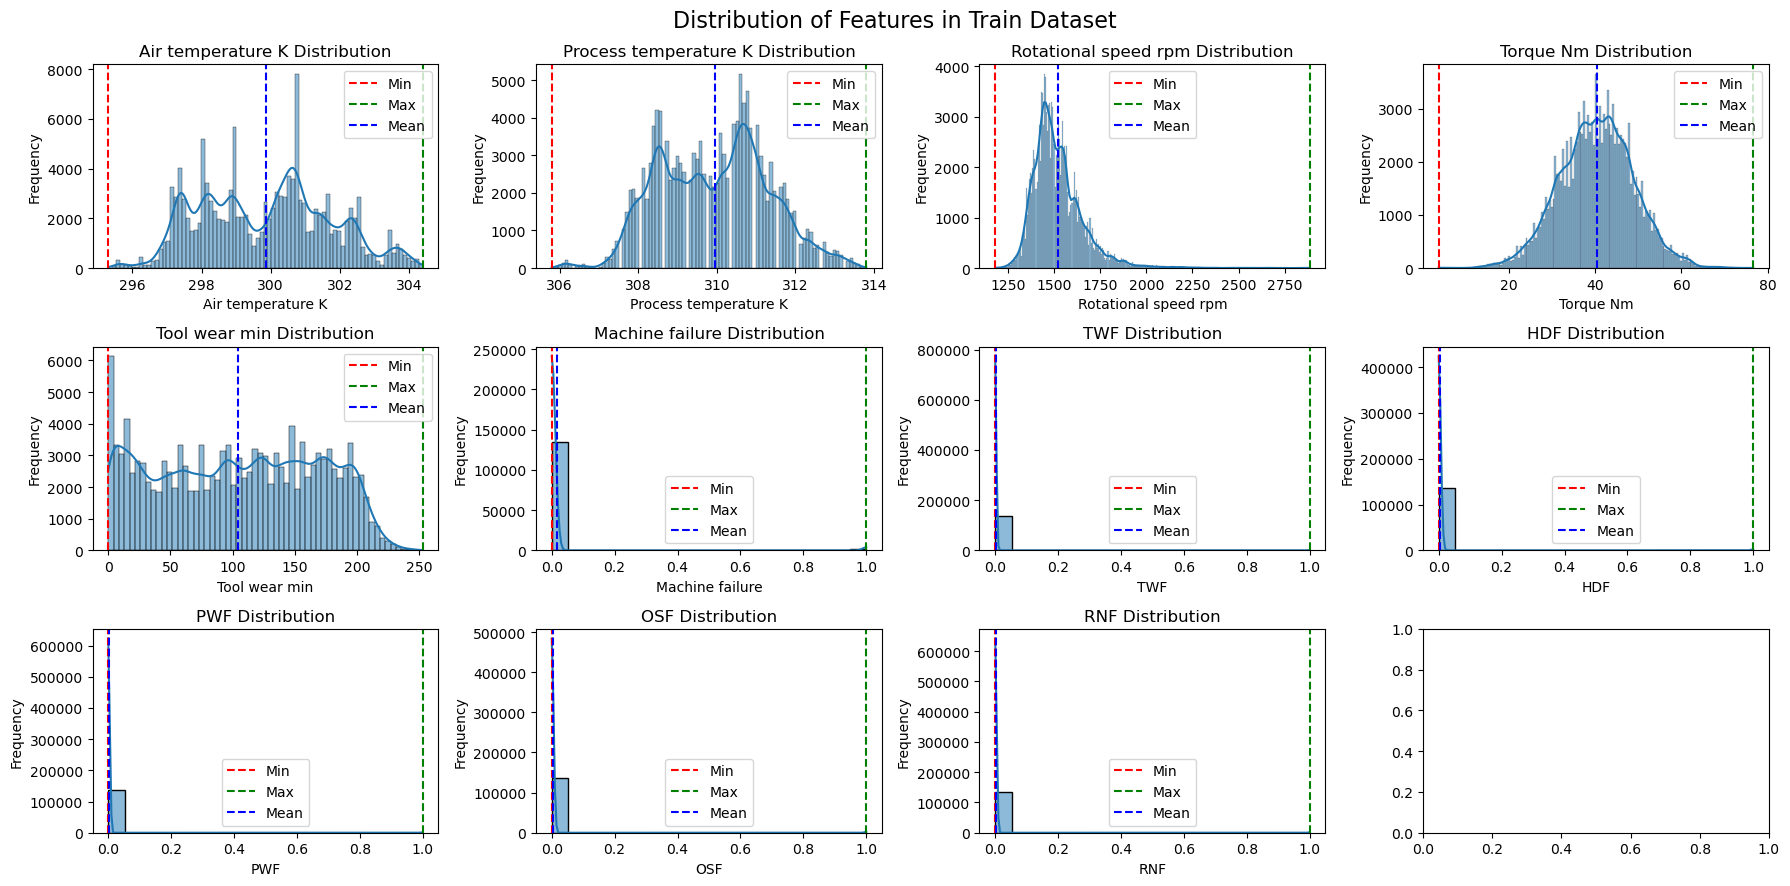

In [10]:
numeric_columns = ['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
num_cols = len(numeric_columns)
num_rows = math.ceil(num_cols / 4)

fig, axes = plt.subplots(num_rows, 4, figsize=(18, num_rows * 3))
fig.suptitle('Distribution of Features in Train Dataset', fontsize=16)

for i, column in enumerate(numeric_columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col] if num_rows > 1 else axes[col]

    sns.histplot(data=train, x=column, kde=True, ax=ax)
    ax.set_title(f'{column} Distribution', fontsize=12)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

    min_value = train[column].min()
    max_value = train[column].max()
    mean_value = train[column].mean()
    ax.axvline(min_value, color='r', linestyle='--', label='Min')
    ax.axvline(max_value, color='g', linestyle='--', label='Max')
    ax.axvline(mean_value, color='b', linestyle='--', label='Mean')
    ax.legend()

fig.tight_layout()
plt.show()

In [11]:
corr = train.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,id,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Machine failure,TWF,HDF,PWF,OSF,RNF
id,1.000000,-0.005338,-0.002396,0.004419,-0.001968,-0.001790,0.001500,-0.000475,-0.000680,0.003275,0.002114,0.000175
Air temperature K,-0.005338,1.000000,0.856080,0.016545,-0.006773,0.016994,0.067744,0.003826,0.100454,0.007967,0.007842,0.004815
Process temperature K,-0.002396,0.856080,1.000000,0.011263,-0.006298,0.012777,0.030966,0.004459,0.041454,0.003871,0.005337,0.004399
Rotational speed rpm,0.004419,0.016545,0.011263,1.000000,-0.779394,0.003983,-0.060868,-0.005765,-0.081996,0.053948,-0.061376,-0.003410
Torque Nm,-0.001968,-0.006773,-0.006298,-0.779394,1.000000,-0.003148,0.145793,0.012983,0.100773,0.050289,0.108765,0.007986
Tool wear min,-0.001790,0.016994,0.012777,0.003983,-0.003148,1.000000,0.056448,0.046470,0.011709,0.007624,0.063604,-0.002071
Machine failure,0.001500,0.067744,0.030966,-0.060868,0.145793,0.056448,1.000000,0.311919,0.564507,0.383941,0.494668,0.001428
TWF,-0.000475,0.003826,0.004459,-0.005765,0.012983,0.046470,0.311919,1.000000,0.010145,0.039927,0.036041,0.002044
HDF,-0.000680,0.100454,0.041454,-0.081996,0.100773,0.011709,0.564507,0.010145,1.000000,0.046680,0.067149,0.000885
PWF,0.003275,0.007967,0.003871,0.053948,0.050289,0.007624,0.383941,0.039927,0.046680,1.000000,0.090016,0.000827


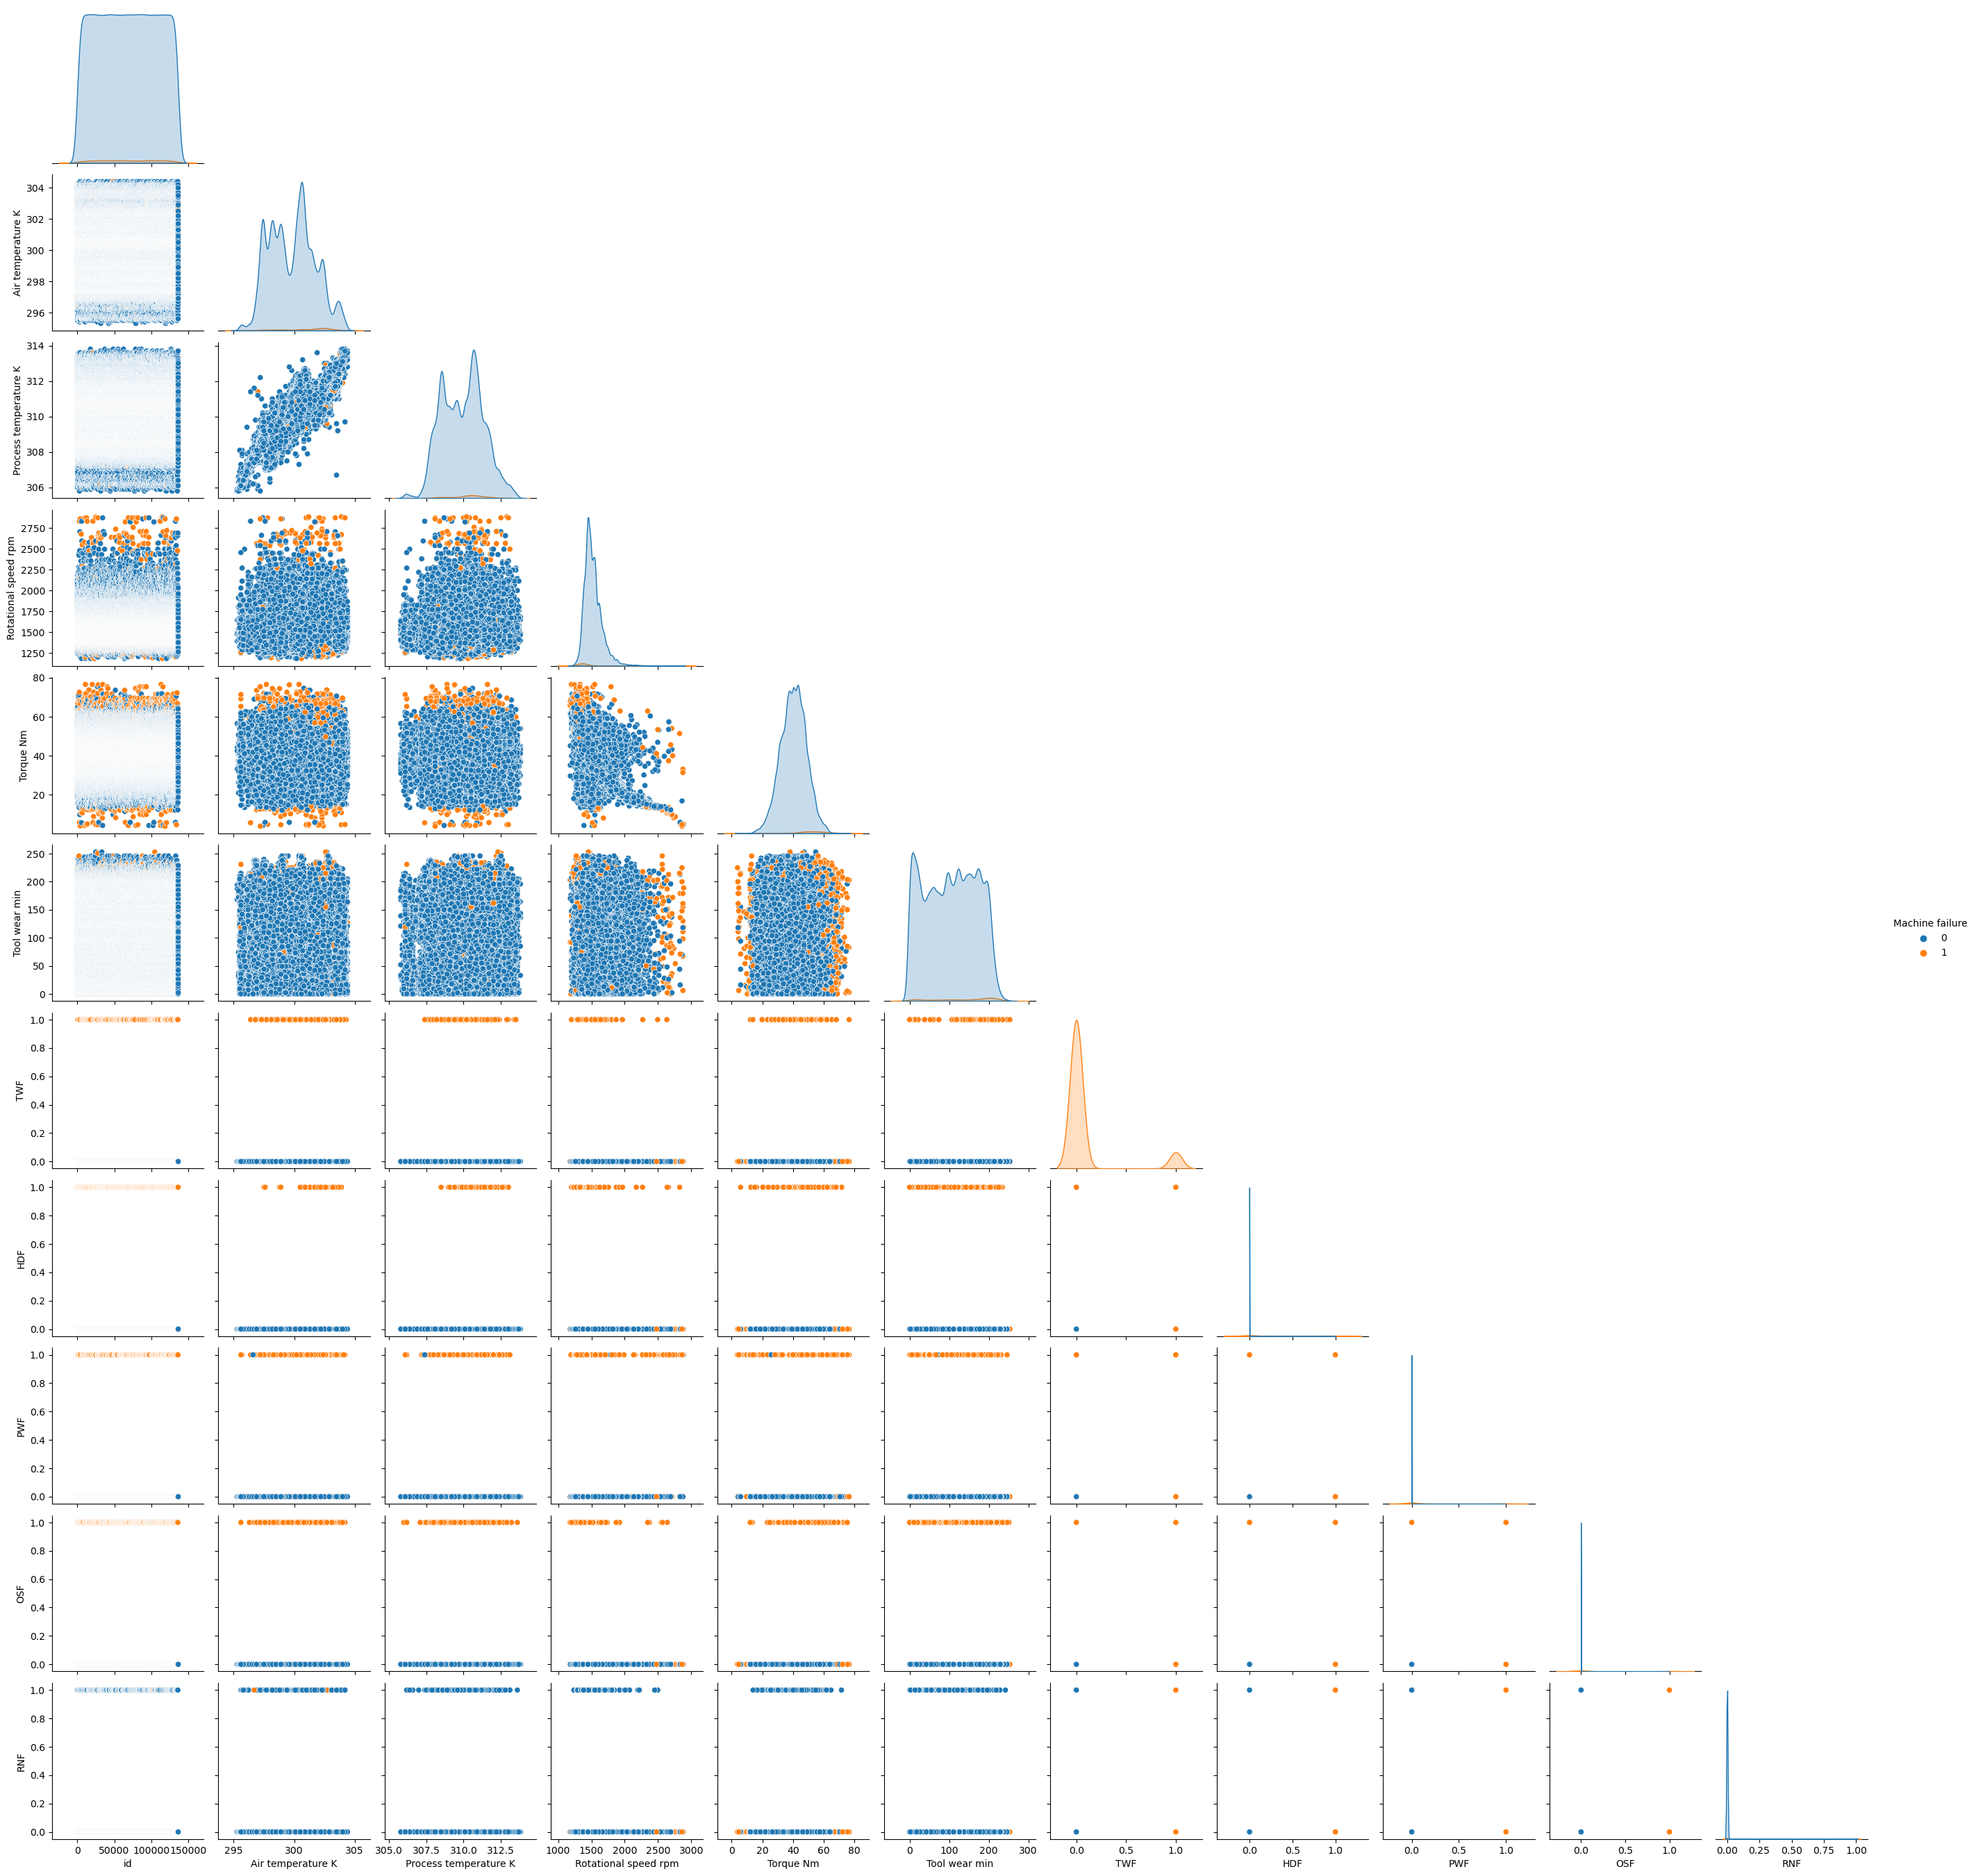

In [12]:
sns.pairplot(data = train, hue="Machine failure", corner = True);

In [13]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [14]:
# numeric_cols = ['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']

# vif = pd.DataFrame()
# vif["features"] = numeric_cols
# vif["vif_factor"] = [variance_inflation_factor(train[numeric_cols].values, i) for i in range(train[numeric_cols].shape[1])]
# vif.sort_values("vif_factor", ascending=False)

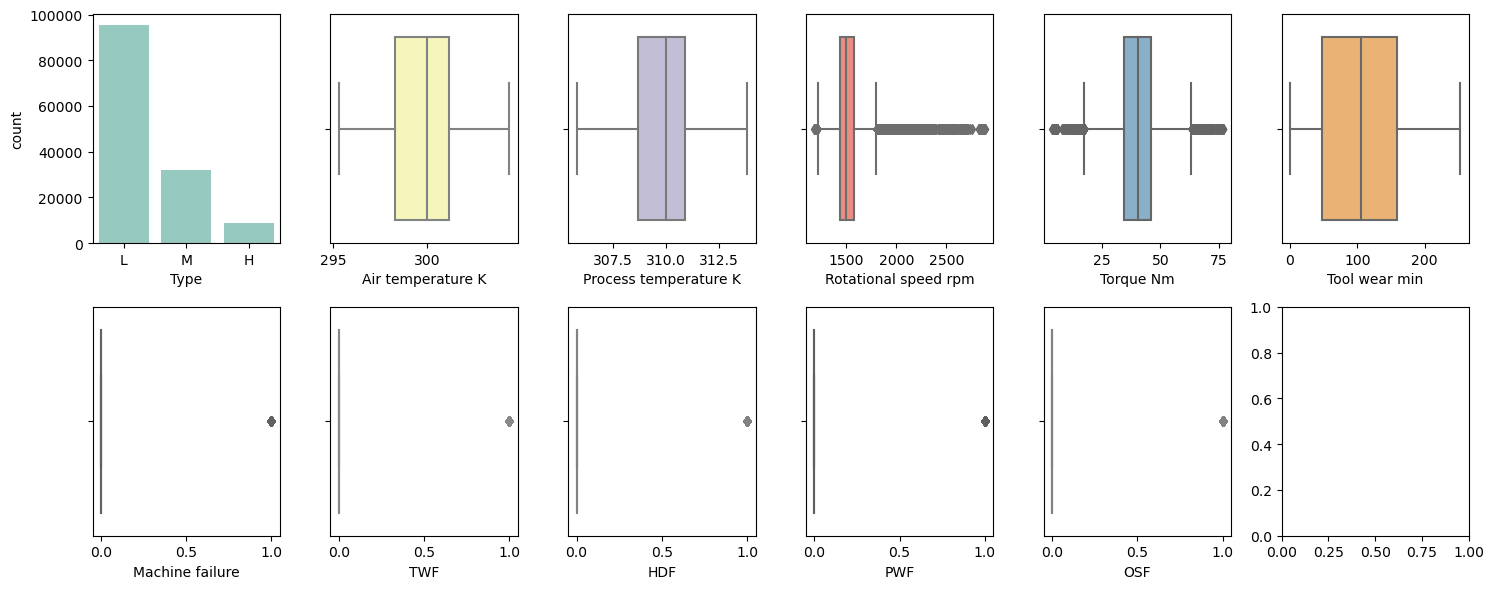

In [15]:
def boxplots(df):
    cols = df.columns[2:-1]
    n = (len(cols) - 1) // 6 + 1
    m = min(len(cols), 6)
    
    palette = sns.color_palette("Set3", len(cols))
    palette_colors = [tuple(palette[i]) for i in range(len(cols))]
    
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15, 6))
    for idx, col in enumerate(cols):
        i = idx // m
        j = idx % m
        if df[col].dtype == 'object':
            sns.countplot(data=df, x=col, ax=axes[i][j], palette=[palette_colors[idx]])
        else:
            sns.boxplot(data=df, x=col, ax=axes[i][j], palette=[palette_colors[idx]])
    
    plt.tight_layout()
    plt.show()

boxplots(train)

In [16]:
categorical_cols = ["Type"]
encoder = OrdinalEncoder()
train[categorical_cols] = encoder.fit_transform(train[categorical_cols])

In [17]:
train["Power"] = train["Torque Nm"] * train["Rotational speed rpm"]
train["temp_ratio"] = train["Process temperature K"] / train["Air temperature K"]

# train['Power'] = train['Rotational speed rpm'] * train['Torque Nm']
    
# train['Temp_diff'] = train['Process temperature K'] - train['Air temperature K']  
# train['Speed_to_Torque_ratio'] = train['Rotational speed rpm'] / train['Torque Nm']  
# train['Temp_sum'] = train['Air temperature K'] + train['Process temperature K']     

In [18]:
y = train.pop("Machine failure")
X = train.drop(["id", "Product ID"], axis=1)
#, "RNF", "Type"

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((109143, 13), (27286, 13), (109143,), (27286,))

In [20]:
test_df = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")
test_df[categorical_cols] = encoder.transform(test_df[categorical_cols])
test_df.columns = test_df.columns.str.replace('[\[\]]', '', regex=True)

test_df["Power"] = test_df["Torque Nm"] * test_df["Rotational speed rpm"]
test_df["temp_ratio"] = test_df["Process temperature K"] / test_df["Air temperature K"]

# test_df['Temp_diff'] = test_df['Process temperature K'] - test_df['Air temperature K']  # Temperature difference
# test_df['Speed_to_Torque_ratio'] = test_df['Rotational speed rpm'] / test_df['Torque Nm']  # Speed to torque ratio
# test_df['Temp_sum'] = test_df['Air temperature K'] + test_df['Process temperature K']  # Temperature sum

ids = test_df["id"]
test_X = test_df.drop(["id", "Product ID"], axis=1)

test_X.shape

(90954, 13)

In [21]:
# lgbm = LGBMClassifier(n_estimators=1000, learning_rate=0.01)
# lgbm.fit(X_train, y_train, early_stopping_rounds=25, eval_set=[(X_val, y_val)], verbose=100)


# preds = lgbm.predict_proba(test_X)
# predicted_prob = [pred[1] for pred in preds]
# print(predicted_prob[:5])

# print('Train score:', lgbm.score(X_train, y_train))
# print('Validation score:', lgbm.score(X_val, y_val))

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

param_dist = {
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [200, 400, 600, 800],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1]
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, cv=3, scoring='accuracy', n_iter=10)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_xgb = XGBClassifier(**best_params)
best_xgb.fit(X_train, y_train)

train_score = best_xgb.score(X_train, y_train)
val_score = best_xgb.score(X_val, y_val)
print("Train score:", train_score)
print("Validation score:", val_score)

Best Hyperparameters: {'subsample': 0.6, 'reg_alpha': 0, 'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Train score: 0.9964725177061287
Validation score: 0.9964817122333798


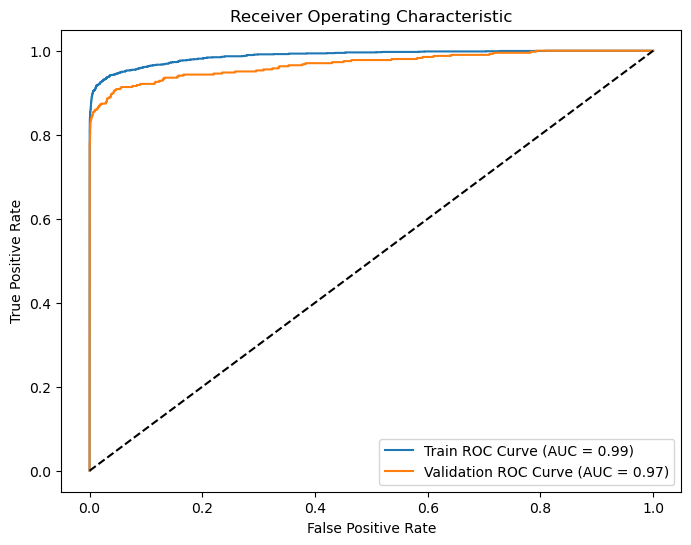

In [23]:
y_train_probs = best_xgb.predict_proba(X_train)[:, 1]
y_val_probs = best_xgb.predict_proba(X_val)[:, 1]


train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_val_probs)

train_auc = roc_auc_score(y_train, y_train_probs)
val_auc = roc_auc_score(y_val, y_val_probs)

plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, label='Train ROC Curve (AUC = {:.2f})'.format(train_auc))
plt.plot(val_fpr, val_tpr, label='Validation ROC Curve (AUC = {:.2f})'.format(val_auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [24]:
# preds = best_xgb.predict_proba(test_X)
# predicted_prob = [pred[1] for pred in preds]

In [25]:
# submission_df = pd.DataFrame({
#     "id": ids,
#     "Machine failure": predicted_prob
# })

In [26]:
# submission_df.to_csv("submission9.csv", index=False)

In [27]:
# preds = xgb.predict_proba(X_val)
# predicted_prob = [pred[1] for pred in preds]

# fpr, tpr, thresholds = roc_curve(y_val, predicted_prob)

# plt.plot(fpr, tpr, label='ROC Curve')
# plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()

# # # Calculate the confusion matrix
# # predicted_labels = (predicted_prob >= 0.5).astype(int)  # Thresholding at 0.5
# # confusion_mat = confusion_matrix(y_val, predicted_labels)

# # print("Confusion Matrix:")
# # print(confusion_mat)

In [28]:
# from catboost import CatBoostClassifier

# catboost = CatBoostClassifier(n_estimators=1000, learning_rate=0.01)
# catboost.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=100)

# preds = catboost.predict_proba(test_X)
# predicted_prob = [pred[1] for pred in preds]
# print(predicted_prob[:5])

# print('Train score:', lgbm.score(X_train, y_train))
# print('Validation score:', lgbm.score(X_val, y_val))

In [29]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(n_estimators=1000)
# rf.fit(X_train, y_train)

# preds = rf.predict_proba(test_X)
# predicted_prob = [pred[1] for pred in preds]
# print(predicted_prob[:5])

# print('Train score:', lgbm.score(X_train, y_train))
# print('Validation score:', lgbm.score(X_val, y_val))

In [30]:
# from sklearn.ensemble import GradientBoostingClassifier

# gb = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
# gb.fit(X_train, y_train)

# preds = gb.predict_proba(test_X)
# predicted_prob = [pred[1] for pred in preds]
# print(predicted_prob[:5])

# print('Train score:', lgbm.score(X_train, y_train))
# print('Validation score:', lgbm.score(X_val, y_val))